## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

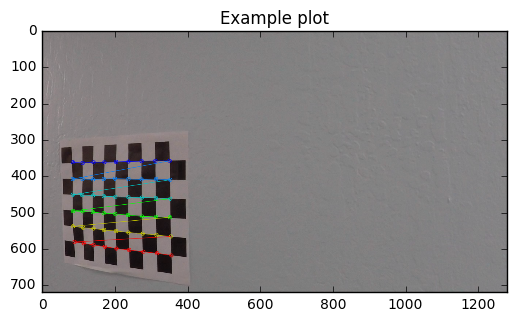

test image- camera_cal/calibration1.jpg
Close the image window to proceed


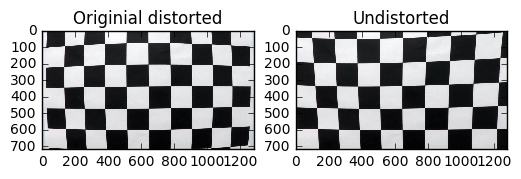

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images[0:len(images)-1]:
    calib_img = cv2.imread(fname)
    gray = cv2.cvtColor(calib_img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw 
        calib_img = cv2.drawChessboardCorners(calib_img, (9,6), corners, ret)
        
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        #cv2.destroyAllWindows()
plt.imshow(calib_img)
plt.title('Example plot')
plt.show()

print('test image- camera_cal/calibration1.jpg')
test_img=cv2.imread('camera_cal/calibration1.jpg')

ret,mtx,dist,rvecs,tvecs,=cv2.calibrateCamera(objpoints,imgpoints,test_img.shape[0:2],None,None)


undist=cv2.undistort(test_img,mtx,dist,None,mtx)
print('Close the image window to proceed')
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title("Originial distorted")
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title("Undistorted")
plt.show()

## Definitions of Color and Gradient Threshold

In [2]:
def abs_sobel_thresh(im, orient='x',sobel_kernel=3, abs_thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(im, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(im, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel_threshold(image,k=3,a_t=(0,255),m_t=(0,255),d_t=(0, np.pi/2)):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=k, abs_thresh=a_t)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=k, abs_thresh=a_t)
    mag_binary = mag_thresh(image, sobel_kernel=k, mag_thresh=m_t)
    dir_binary = dir_threshold(image, sobel_kernel=k,dir_thresh=d_t)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def hls_select(img, s_thresh=(0, 255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s=hls[:,:,2]
    binary_output=np.zeros_like(s)
    binary_output[(s>s_thresh[0])&(s<=s_thresh[1])]=1
    return binary_output
def color_gradient_threshold(img,method='ColnGrad-combined',ori='x',ks=3,abs_t=(0,255),mag_t=(0,255),dir_t=(0, np.pi/2),s_t=(0, 255)):
    if method=='ColnGrad-combined':
        bin_sobel_out=combined_sobel_threshold(img,k=ks,a_t=abs_t,m_t=mag_t,d_t=dir_t)
        bin_color_out=hls_select(img, s_thresh=s_t)
        binary = np.zeros_like(bin_sobel_out)
        binary[(bin_sobel_out==1) | (bin_color_out == 1)] = 1
    elif method=='ColnGrad-abs':
        bin_sobel_out=abs_sobel_thresh(img, orient=ori,sobel_kernel=ks, abs_thresh=abs_t)
        bin_color_out=hls_select(img, s_thresh=s_t)
        binary = np.zeros_like(bin_sobel_out)
        binary[(bin_sobel_out==1) | (bin_color_out == 1)] = 1
    elif method=='ColnGrad-mag':
        bin_sobel_out=mag_thresh(img, sobel_kernel=ks, mag_thresh=mag_t)
        bin_color_out=hls_select(img, s_thresh=s_t)
        binary = np.zeros_like(bin_sobel_out)
        binary[(bin_sobel_out==1) | (bin_color_out == 1)] = 1
    elif method=='Color_only':
        binary=hls_select(img, s_thresh=s_t)
    elif method=='mag_only':
        binary=mag_thresh(img, sobel_kernel=ks, mag_thresh=mag_t)
    elif method=='abs_only':
        binary=abs_sobel_thresh(img, orient=ori,sobel_kernel=ks, abs_thresh=abs_t)
    else:
        print('Unknown Method Specified-ColnGrad-abs implemented and returned')
        bin_sobel_out=abs_sobel_thresh(img, orient=ori,sobel_kernel=ks, abs_thresh=abs_t)
        bin_color_out=hls_select(img, s_thresh=s_t)
        binary = np.zeros_like(bin_sobel_out)
        binary[(bin_sobel_out==1) | (bin_color_out == 1)] = 1

    return binary

## Perspective Transform Definition

In [3]:
def perspective_transform(img,src,dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped= cv2.warpPerspective(img, M, (img_size[0],img_size[1]))
    return Minv,warped
    

## Finding Lane Definition

In [4]:
def finding_lane(img,nwindows=9,margin = 100,minpix = 50):
    histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img,img,img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = [] 
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img,left_fit,right_fit,nonzerox,nonzeroy,left_lane_inds,right_lane_inds

## Testing threshold and Perspective transform

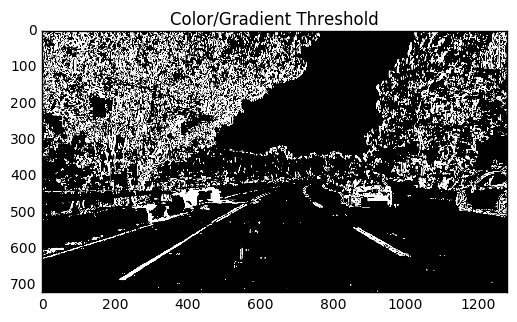

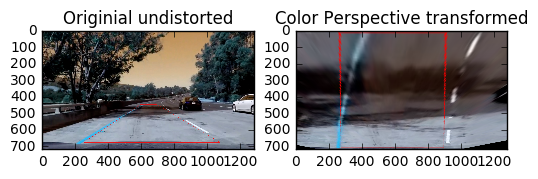

In [5]:
input_img = cv2.imread('test_images/test5.jpg')
#mtx and dst are from cliberation step see the begining
undistorted_img=cv2.undistort(input_img,mtx,dist,None,mtx)
#Tweak or tune parameters for thresholding as deemed appropriate
binary_thresholded=color_gradient_threshold(undistorted_img,method='ColnGrad-abs',ori='x',ks=7,abs_t=(20,100),mag_t=(30,100),dir_t=(0.7, 1.3),s_t=(180, 255))
#Display Thresholded image
plt.imshow(binary_thresholded,cmap='gray')

plt.title("Color/Gradient Threshold")
plt.show()
#Defining Source and Destination for Perspective Transform
pts = np.array([[590,450],[690,450],[1070,680],[250,680]], np.int32)
pts = pts.reshape((-1,1,2))
copy_original=np.copy(undistorted_img)
#offset=0
img_size = (binary_thresholded.shape[1], binary_thresholded.shape[0])
copy_img = cv2.polylines(copy_original,[pts],True,(255,0,0))

#provided in write up src=np.float32([[585, 460],[695, 460],[1127, 720],[203, 720]])
#offset=0
#old one 
src=np.float32([[580,450],[705,450],[1280,710],[100,710]])
#src=np.float32([[585, 460],[695, 460],[1127, 720],[203, 720]])
#offset=100
#dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
dst=np.float32([[200, 0],[1000, 0],[1000, 720],[200, 720]])
Minv,color_pt=perspective_transform(copy_original,src,dst)

#Display Color Perspective Transformed image
plt.subplot(1,2,1)
plt.imshow(copy_original)
plt.title("Originial undistorted")
plt.subplot(1,2,2)
plt.imshow(color_pt)
plt.title("Color Perspective transformed")
plt.show()
# Using same parameters tranform binary thresholded image
Minv,binary_pt=perspective_transform(binary_thresholded,src,dst)

## Finding Lane line on test image

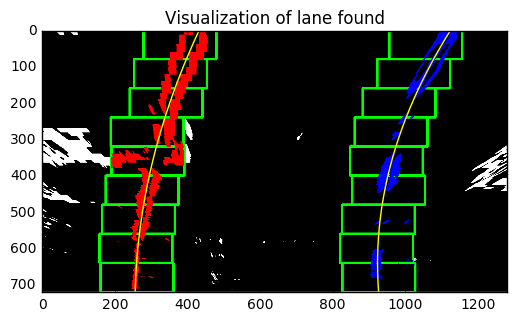

In [6]:
out_img,left_fit,right_fit,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=finding_lane(binary_pt,nwindows=9,margin = 100,minpix = 50)
#Visualizing the lane find method
ploty = np.linspace(0, binary_pt.shape[0]-1, binary_pt.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Visualization of lane found")
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Measuring Radius of Curvature

In [7]:
y_eval = np.max(ploty)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


533.998921642 m 337.306659827 m


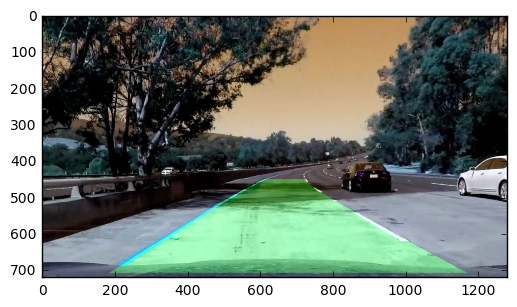

In [8]:
warp_zero = np.zeros_like(binary_pt).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
cv2.imwrite('output_images/marked_lane.jpg',result)
plt.imshow(result)
plt.show()

## Video Process Pipeline

In [9]:
def approxi_lane_line(nonzero,lbest_fit,rbest_fit):
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (lbest_fit[0]*(nonzeroy**2) + lbest_fit[1]*nonzeroy + lbest_fit[2] - margin)) & (nonzerox < (lbest_fit[0]*(nonzeroy**2) + lbest_fit[1]*nonzeroy + lbest_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (rbest_fit[0]*(nonzeroy**2) + rbest_fit[1]*nonzeroy + rbest_fit[2] - margin)) & (nonzerox < (rbest_fit[0]*(nonzeroy**2) + rbest_fit[1]*nonzeroy + rbest_fit[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [10]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def rad_of_curvature(left_fitx,right_fitx,ploty):     
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
    
    return left_curverad,right_curverad

def deviation_from_center(l_point,r_point,i_size):
    #center_of_lane=abs(right_fitx[-1]+left_fitx[-1]/2)
    center_of_lane=abs((r_point+l_point)/2)
    center_of_car=abs(i_size)/2 #equivalent to center of image
    dist_fr_center=abs(center_of_lane-center_of_car)*xm_per_pix
    return dist_fr_center

In [28]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #list of last n iterations
        self.poly_fit=[]
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #Previous normal line base_pos
        self.previous_line_base_pos=None
        

left_line = Line()
right_line = Line()
count=0
n_iterations=5

def process(input_img,met='ColnGrad-abs',o='x',K=7,AT=(20,100),MT=(30,100),DT=(0.7, 1.3),ST=(160, 255),NWIN=9,MARG = 100,MIPIX = 50):
    global left_line 
    global right_line 
    global count
    global n_iterations
    global mtx
    global dist
    
    ploty = np.linspace(0, input_img.shape[1]-1, input_img.shape[1] )
    
    y_eval = np.max(ploty)
    
    #Camera Calibration and undistrotion
    undistorted_img=cv2.undistort(input_img,mtx,dist,None,mtx)
    
    # Binary Thresholding by Color and Gradient Threshold
    binary_thresholded=color_gradient_threshold(undistorted_img,method=met,ori=o,ks=K,abs_t=AT,mag_t=MT,dir_t=DT,s_t=ST)
    
    #Initializing Image size and Parameters needed for Perspective transform
    img_size = (binary_thresholded.shape[1], binary_thresholded.shape[0])
    src=np.float32([[585, 460],[695, 460],[1127, 720],[203, 720]])
    dst=np.float32([[200, 0],[1000, 0],[1000, 720],[200, 720]])
    
    # Perspective transform- Binary Warped 
    Minv,binary_pt=perspective_transform(binary_thresholded,src,dst)
    
    
    if left_line.detected==False: 
        #Window searching for lane lines
        out_img,left_fit,right_fit,nonzerox,nonzeroy,left_lane_inds,right_lane_inds=finding_lane(binary_pt,nwindows=NWIN,margin = MARG,minpix = MIPIX)
        
        if count==(n_iterations-1):
            left_line.detected=True
            right_line.detected=True
            count=0
        else:
            count=count+1
        
    else:
        nonzero = binary_pt.nonzero()
        left_fit,right_fit=approxi_lane_line(nonzero,left_line.best_fit,right_line.best_fit)
        
        if count==(n_iterations-1):
            left_line.detected=False
            right_line.detected=False
            count=0
        else:
            count=count+1

    left_line.current_fit=left_fit
    right_line.current_fit=right_fit
        
    if (len(left_line.poly_fit)>=5):
        unwanted=left_line.poly_fit.pop(0)
        unwanted=right_line.poly_fit.pop(0)
        
    #Updating the list with latest fits
    left_line.poly_fit.append(left_fit)
    right_line.poly_fit.append(right_fit)
    
    #Computing the best fit
    left_line.best_fit=np.average(left_line.poly_fit,axis=0)
    right_line.best_fit=np.average(right_line.poly_fit,axis=0)
    
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    #Calculate Radius of Curvature
    left_curverad,right_curverad=rad_of_curvature(left_fitx,right_fitx,ploty)
    
    #Calculating Distance from center
    dist_fr_center=deviation_from_center(left_fitx[-1],right_fitx[-1],img_size[0])
    
    #It was observered that when approximated lane line method is employed
    # to find the lane line deviation of car is out of  limits due to approximation of best fit
    #but when window search lane lines are detected the value goes above 1 TO avoid this situation
    
    if dist_fr_center<1.:
        left_line.previous_line_base_pos=dist_fr_center
   
    if (left_line.detected==True) & (dist_fr_center>1.): 
        dist_fr_center=left_line.previous_line_base_pos

    
    left_line.radius_of_curvature=left_curverad
    right_line.radius_of_curvature=right_curverad
    
    left_line.line_base_pos=dist_fr_center
    right_line.line_base_pos=dist_fr_center
    
    warp_zero = np.zeros_like(binary_pt).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "radius of curvature={:.2f} m ".format((right_line.radius_of_curvature+left_line.radius_of_curvature)/2)
    text1 = "Distance of car from center of lane={:.2f} m".format(left_line.line_base_pos)
    cv2.putText(result,text,(200,50), font, 1,(255,255,255),2)
    cv2.putText(result,text1,(200,100), font, 1,(255,255,255),2)
    
    #priliminay sanity check
    right_san_check=(((right_line.radius_of_curvature/1000)>10) | ((right_line.radius_of_curvature/1000)<0.1))
    left_san_check=(((left_line.radius_of_curvature/1000)>10) | ((left_line.radius_of_curvature/1000)<0.1))
    if right_san_check & left_san_check:
        text="error in curvature san. check!"
        cv2.putText(result,text,(200,150), font, 1,(255,0,0),2)
    
    return result

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [02:24<00:00,  8.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 17min 2s, sys: 6.73 s, total: 17min 9s
Wall time: 2min 25s
